In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from modules.Utils.utils import DummyLogger
import sqlite3
from tqdm import tqdm
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
from tqdm.notebook import tqdm_notebook
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries

%matplotlib inline

In [2]:
db_path = 'kpf_ts_oct2024_v3.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/kpf_ts_oct2024_v3.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 33057 obs x 1214 cols over 57 days in 20240901-20241027; updated 2025-02-27 03:47:04


In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute(
    """
    SELECT keyword, description
    FROM kpfdb_metadata
    WHERE source = "L2 RV Extension"
    ORDER BY keyword;
    """)
rows = cursor.fetchall()
keywords = [f'"{keyword}"' for keyword, description in rows if keyword]

query = f"""SELECT ObsID, OBJECT, [DATE-MID], NOTJUNK, GOODREAD, CCFBCV, CCFBJD as 'CCFBJD_Avg', BCVRNG, BCVSTD, EXPTIME, GAIAMAG, [2MASSMAG], TARGTEFF, [EMDATE-B], [EMDATE-E], L0_filename,   
    {', '.join(keywords)} 
    FROM kpfdb
    WHERE NOTJUNK = 1.0 AND OBJECT NOT LIKE '%autocal%' AND Source = 'Star' AND EXPTIME != 0.0 """
df = pd.read_sql_query(query, conn)
conn.close()
df

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,1,None,-0.735386,2.460555e+06,NaN,NaN,60.0,...,0.0,73.9994503492939,87.6714544762298,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KP.20240901.25818.06,201092,2024-09-01T07:10:48.073,1,None,-0.738219,2.460555e+06,NaN,NaN,60.0,...,0.0,76.5204767988828,-60.1857207938152,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KP.20240901.25926.46,201092,2024-09-01T07:12:36.475,1,None,-0.741102,2.460555e+06,NaN,NaN,60.0,...,0.0,-8.66980641338825,17.2859798390395,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20240901.26200.94,TIC198162530,2024-09-01T07:21:40.954,1,None,-3.289237,2.460555e+06,NaN,NaN,600.0,...,0.0,-95.7725969275614,-90.7507848517297,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KP.20240901.26961.63,142373,2024-09-01T07:29:51.644,1,None,-12.738138,2.460555e+06,NaN,NaN,60.0,...,0.0,-60.2793117313946,-60.523441115301,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,KP.20241026.49181.48,52711,2024-10-26T13:44:04.989,1,None,28.050886,2.460610e+06,0.096732,0.020964,527.0,...,0.0,22.7169217062974,-38.2785349674322,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4496,KP.20241026.49992.37,HIP37217,2024-10-26T14:04:50.091,1,None,22.411861,2.460610e+06,1.072112,0.269831,1569.0,...,0.0,-1.92022982588995,65.4683625601405,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4497,KP.20241026.51667.01,44219,2024-10-26T14:22:18.551,1,None,21.881098,2.460610e+06,0.127194,0.029238,143.0,...,0.0,-112.696855858522,15.7976897824488,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4498,KP.20241026.52204.35,HAT-P-20,2024-10-26T14:37:01.365,1,None,29.100836,2.460610e+06,2.947692,0.721304,1685.0,...,0.0,30.9935161416225,0.353441354465979,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#identifying columns to reshape (the ones ending with digits)
columns_to_reshape = [col for col in df.columns if col[-2:].isdigit()]

#extracting ORDER and prefix from the column names
order_list = []
prefix_list = []
for col in columns_to_reshape:
    prefix = col[:-2]  # Extract the prefix (e.g., 'BCRV')
    order = col[-2:]   # Extract the order (e.g., '00')
    prefix_list.append(prefix)
    order_list.append(order)

#creating new dataframe with ORDER 
unique_orders = sorted(set(order_list))  # Unique ORDER values
new_df = pd.DataFrame({
    'ORDER': unique_orders,
})

#add preserved columns to the new dataframe
preserved_columns = ['ObsID', 'OBJECT', 'DATE-MID', 'CCFBCV', 'CCFBJD_Avg', 'BCVRNG', 'BCVSTD', 'EXPTIME', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EMDATE-B', 'EMDATE-E', 'L0_filename']
temp_df = df[preserved_columns].assign(key=1)
new_df = new_df.assign(key=1).merge(temp_df, on='key', how='outer').drop('key', axis=1)

#adding columns for each unique prefix
unique_prefixes = set(prefix_list)
for prefix in unique_prefixes:
    new_df[prefix] = None  # Initialize the column with None

#populating the new DataFrame with values from the original DataFrame
for i, col in enumerate(columns_to_reshape):
    prefix = prefix_list[i]
    order = order_list[i]
    new_df.loc[new_df['ORDER'] == order, prefix] = df[col].values

#sorting the DataFrame by preserved columns and ORDER
new_df = new_df.sort_values(by=preserved_columns + ['ORDER']).reset_index(drop=True)

new_df

,ORDER,ObsID,OBJECT,DATE-MID,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,GAIAMAG,...,RVS,RVC,CCFBJD,ERVC,RV3,RVY,ERVS,BCRV,ERVY,RV2
0,00,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,2460554.80228612,0.0,0.0,0.0,0.00371330351343654,-0.735393310978223,0.0,0.0
1,01,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,2460554.80228201,0.0,0.0,0.0,0.00353493677869039,-0.735383983169038,0.0,0.0
2,02,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,2460554.80228251,0.0,0.0,0.0,0.00271216561490699,-0.735385113215487,0.0,0.0
3,03,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,2460554.80228298,0.0,0.0,0.0,0.00283316785135073,-0.735386190340934,0.0,0.0
4,04,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,2460554.80228258,0.0,0.0,0.0,0.00228852358975969,-0.735385270746997,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301495,62,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0,0.00914154823921011,2460610.12080313,0.000475514395909022,0.0,0.0,0.0,24.1976159080732,0.0,0.0
301496,63,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0,-0.000684368049018988,2460610.12079732,0.000440153840225037,0.0,0.0,0.0,24.1976221527514,0.0,0.0
301497,64,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0,0.0114146858877544,2460610.12079346,0.00086853335713448,0.0,0.0,0.0,24.1976263076159,0.0,0.0
301498,65,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0,-0.00788511566110868,2460610.12079598,0.00080678890915096,0.0,0.0,0.0,24.197623595531,0.0,0.0


In [5]:
#filtering out zero weights
new_df = new_df.loc[new_df['CCFW'].astype(float) > 0.0].copy()

#creating percent change deviation for BCRV
new_df.loc[:, 'BCRV_Perc'] = (new_df['BCRV'].astype(float) - new_df['CCFBCV'].astype(float)) / (new_df['CCFBCV'].astype(float)) * 100

new_df = new_df.sort_values(by=['ORDER'], ascending=True)
new_df['DATE-MID'] = pd.to_datetime(new_df['DATE-MID'])

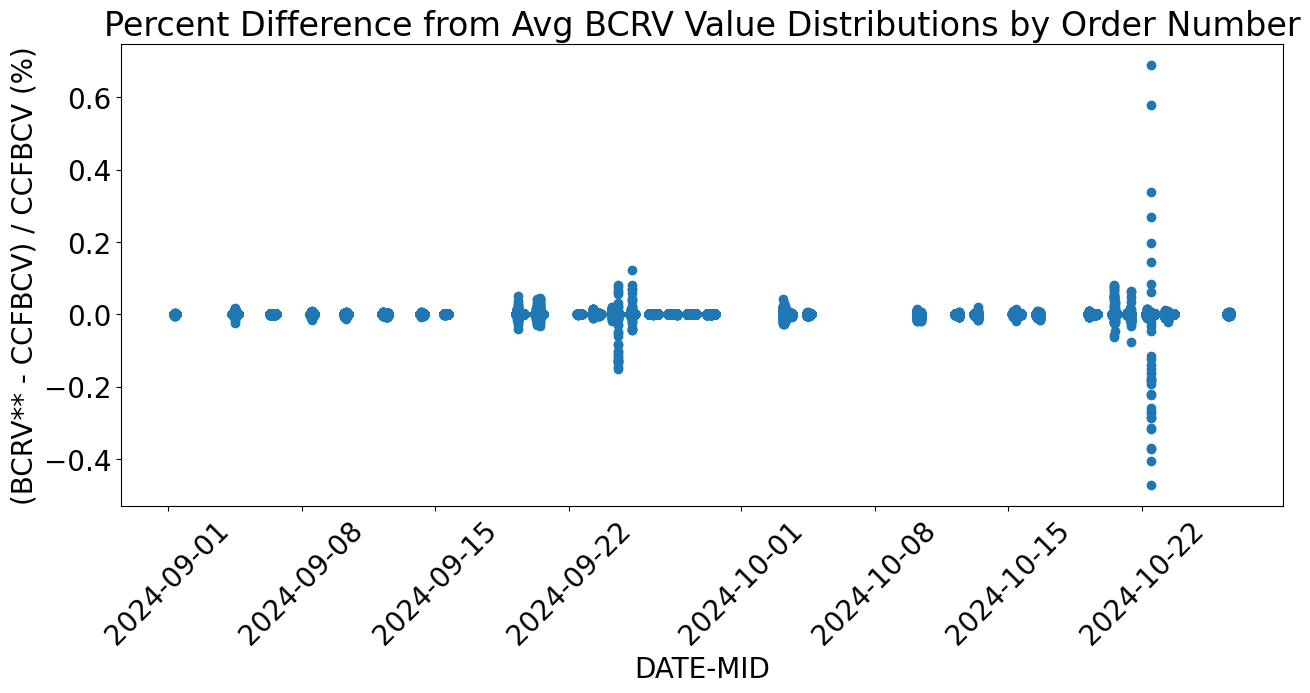

In [6]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
plt.scatter(new_df['DATE-MID'], new_df['BCRV_Perc'])
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("Percent Difference from Avg BCRV Value Distributions by Order Number")
plt.ylabel('(BCRV** - CCFBCV) / CCFBCV (%)')
plt.xlabel('DATE-MID')
plt.show()

In [7]:
Sort_High = new_df.sort_values(by=['BCRV_Perc'], ascending=False)
Sort_High[['BCRV_Perc', 'L0_filename']].head()

,BCRV_Perc,L0_filename
288589,0.689437,KP.20241022.39422.56.fits
288590,0.577378,KP.20241022.39422.56.fits
288585,0.336957,KP.20241022.39422.56.fits
288586,0.269550,KP.20241022.39422.56.fits
288594,0.198016,KP.20241022.39422.56.fits
